les pip :
spacy
spacy-lefff
collections
pandas
git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git

le reste :
spacy download fr_core_news_sm 

In [66]:
#Imports
import spacy 
#from spacy_lefff import LefffLemmatizer --> utile ?
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [36]:
#Reader/set up
#lire csv et convert en table
#table=pd.Dataframe(data=, columns=["Titre","Texte"])
nlp = spacy.load("fr_core_news_sm")  #modèle français
stop_words_fr = nlp.Defaults.stop_words #liste de stopwords fr

In [58]:
#Lemmatiseurs
def lemmatizer (txt) :
    txt_lemma =[t.lemma_ for t in nlp(txt)]
    txt_lemma = [t for t in txt_lemma if t not in stop_words_fr]#lemmes sans les stopswords

    
    return txt_lemma #peu précis (NP pas tj reconnus, vb quand faut pas...)

def CC_lemmatizer (txt) :
    txt_token =[t.text for t in nlp(txt) if t.text not in stop_words_fr]#mieux que juste split et stop_words pour éviter des erreurs de lecture
    lemmatizer = FrenchLefffLemmatizer()
    lemma_CC=[lemmatizer.lemmatize(t,'all')[0] for t in txt_token if len(lemmatizer.lemmatize(t,'all'))!=0]#cette fonction prend les textes et non la version fr_core_news_sm
    txt_lemma_CC=[t[0] for t in lemma_CC if t[0] not in stop_words_fr]#que lemmes CC
    return txt_lemma_CC #meilleur mais perte des chiffres

#Exemple    
sample_txt="Le malheureux Dantès désespère dans sa captivité pendant 4 ans jusqu'à songer au suicide. Il a la chance de faire la connaissance de l'abbé Faria, un autre prisonnier qui, voulant s'évader, a creusé un tunnel qui débouche non sur la mer mais dans la cellule de Dantès, et sauve Dantès qui se laissait mourir de faim. Edmond Dantès découvre alors en l'abbé Faria une personne exceptionnelle, érudit dans tous les domaines scientifiques et philosophiques. L'abbé Faria fait la lumière sur le complot machiné contre Edmond en lui montrant son écriture de la main gauche qui ressemble étrangement à celle de la lettre et en lui expliquant que M. Noirtier est en réalité le père de Villefort. Ces révélations instillent la vengeance dans le cœur d'Edmond. L'abbé Faria, très érudit, se lie d'amitié avec Dantès et lui donne une éducation exceptionnelle tant en économie qu'en sciences, en politique, en philosophie mais aussi en langues. Faria fait une première crise de catalepsie qui le laisse paralysé d'un bras et d'une jambe rendant ainsi l'évasion qu'ils préparaient impossible. Il lui fait alors part d'un secret qui le fait lui-même passer pour fou aux yeux de ses geôliers et, pendant un court moment, de Dantès : il est le dépositaire d'un immense trésor, celui des Spada, enfoui depuis des siècles dans l'île de Monte Cristo. Le vieux prêtre meurt d'un troisième accès et Edmond, pensant pouvoir s'échapper, prend la place du cadavre dans le linceul, en se munissant d'un couteau au cas où il serait découvert. Il comprend au dernier moment que tous les prisonniers morts en captivité sont jetés à la mer avec aux pieds un boulet de trente-six1 au château d'If et se libère grâce à son couteau. Sa captivité aura duré quinze ans. Edmond nage jusqu'à l'île de Tiboulen et est récupéré par un bateau de contrebandiers avec lesquels il noue des liens. C'est grâce à ce bateau, sur lequel il travaille temporairement comme marin, qu'il parvient à atteindre l'île de Monte-Cristo. Devenu très riche grâce au trésor des Spada dont il prend possession, Dantès retourne à Marseille où il apprend la mort de son père et constate la disparition de ses quatre « amis » : Danglars, Fernand, Caderousse et Villefort."

sample_lemma=lemmatizer(sample_txt)
sample_lemma_CC=CC_lemmatizer(sample_txt)
print(sample_lemma[:15],"\n",sample_lemma_CC[:15])



['malheureux', 'dantè', 'désespèr', 'captivité', '4', 'an', 'songer', 'suicide', '.', 'chance', 'faire', 'connaissance', 'abbé', 'faria', ','] 
 ['malheureux', 'Dantès', 'désespérer', 'captivité', 'an', 'songer', 'suicide', '.', 'chance', 'faire', 'connaissance', 'abbé', 'Faria', ',', 'prisonnier']


In [62]:
#Stats
def summary_table (txt,txt_lemma) :   
    txt_type=[(t.lemma_,t.tag_) for t in nlp(txt)]

    d_type=pd.DataFrame(data=txt_type, columns=['Word','Type'])
    tk_count=Counter(txt_lemma)
    d_count=pd.DataFrame.from_dict(data=tk_count,orient='index',columns=["Count"])
    d_count=d_count.reset_index()
    d_count=d_count.rename(columns={"index":"Word"})
    d_final=d_type.merge(d_count,on='Word')
    d_final=d_final.rename_axis(index='Order')
    d_final=d_final.drop_duplicates(subset=['Word'])#deletes redundancies
    return d_final

#Exemple
d_sum=summary_table(sample_txt,sample_lemma)
d_sum_CC=summary_table(sample_txt,sample_lemma_CC)
print(d_sum.sort_values('Count',ascending=False),"\n\n", d_sum_CC.sort_values('Count',ascending=False))#tj plus efficace


             Word   Type  Count
Order                          
14              ,  PUNCT     21
8               .  PUNCT     14
10          faire   VERB      5
32         Edmond  PROPN      5
12           abbé   NOUN      4
...           ...    ...    ...
216           ami   NOUN      1
217             »  PROPN      1
219      Danglars  PROPN      1
221       Fernand  PROPN      1
223    Caderousse  PROPN      1

[145 rows x 3 columns] 

              Word   Type  Count
Order                          
10              ,  PUNCT     21
5               .  PUNCT     14
21         Dantès  PROPN      7
26         Edmond  PROPN      5
60          Faria  PROPN      5
...           ...    ...    ...
179           ami   NOUN      1
180             »  PROPN      1
182      Danglars  PROPN      1
184       Fernand  PROPN      1
186    Caderousse  PROPN      1

[119 rows x 3 columns]


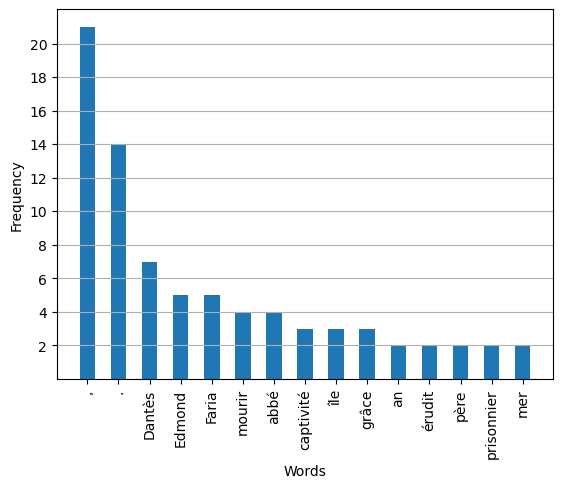

In [77]:
#Graphs
#plt.hist(d_sum_CC)
d_sorted=d_sum_CC.sort_values('Count',ascending=False).head(15)
plt.bar(d_sorted['Word'], d_sorted['Count'], width=0.5)
plt.xticks(rotation='vertical')
plt.yticks(range(min(d_sorted['Count']),max(d_sorted['Count']),2))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

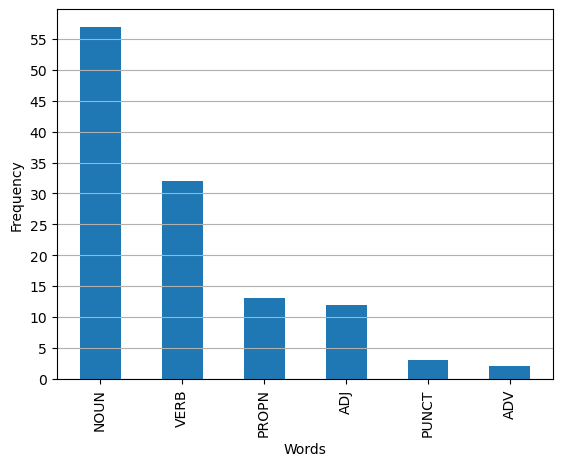

In [ ]:
d=d_sum_CC['Type'].value_counts()
plt.bar(d.index, d.values, width=0.5)
plt.xticks(rotation='vertical')
plt.yticks(range(0,max(d_sum_CC['Type'].value_counts().values),5))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()